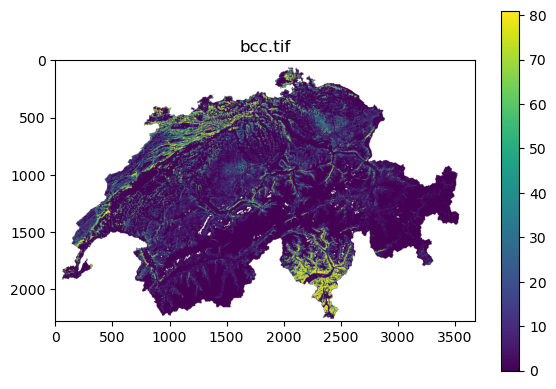

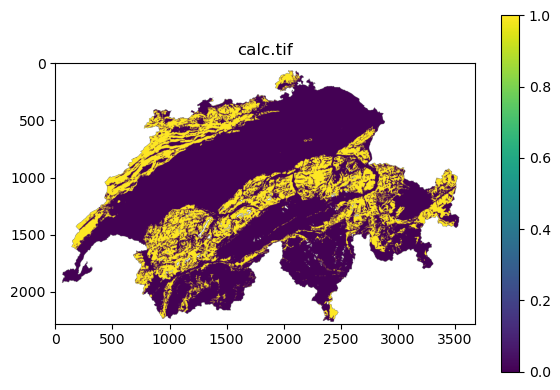

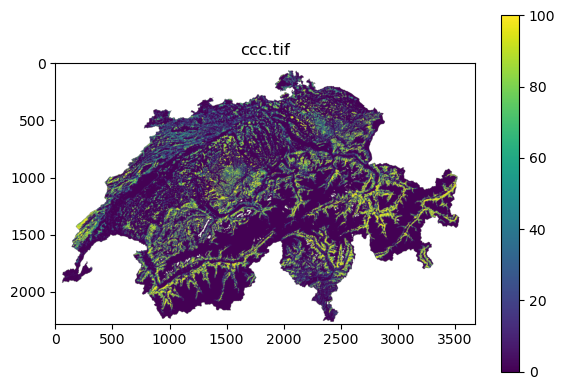

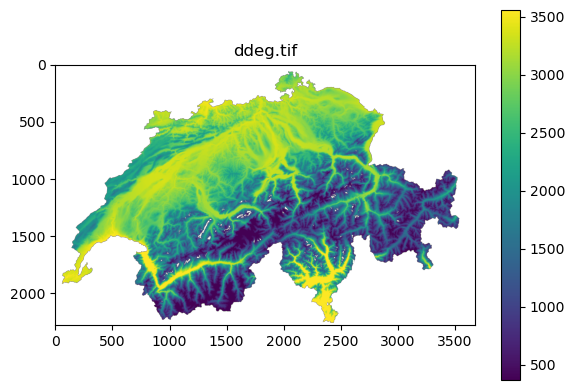

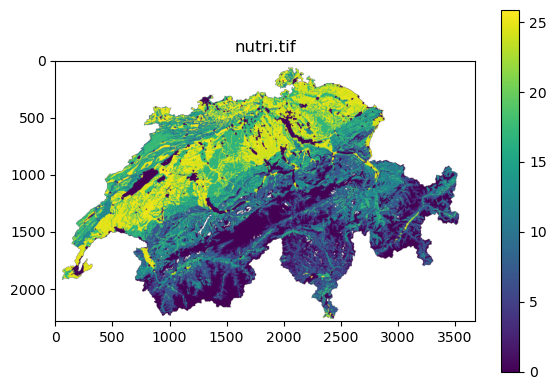

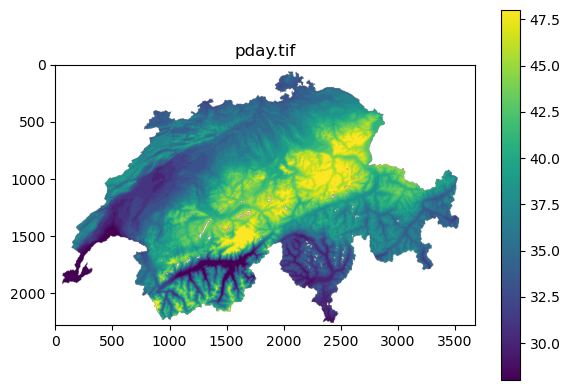

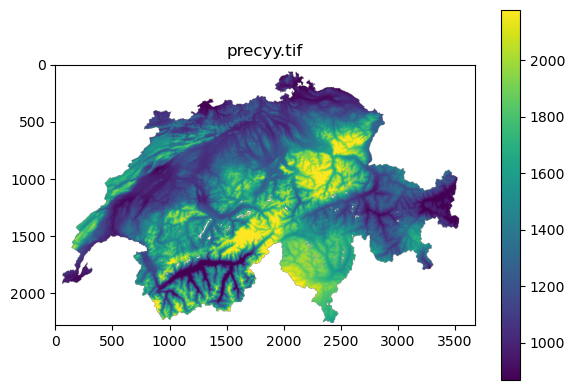

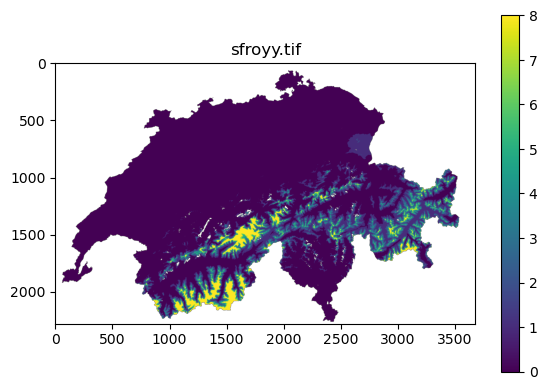

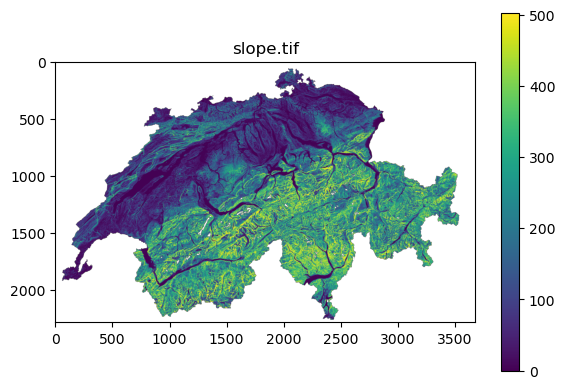

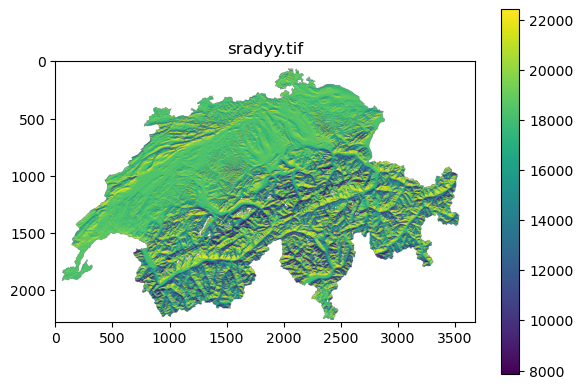

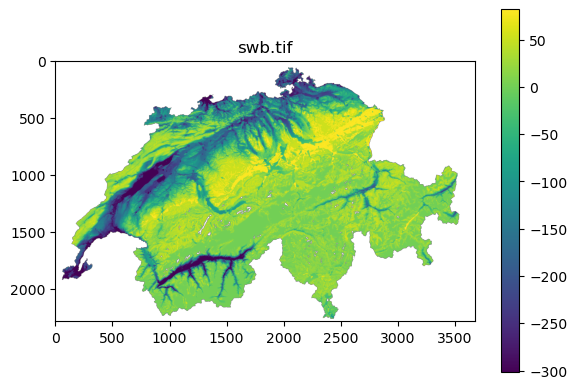

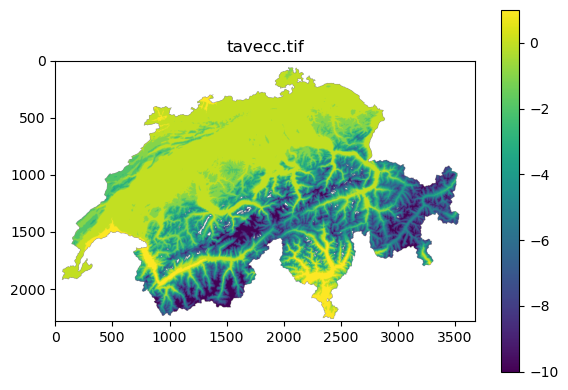

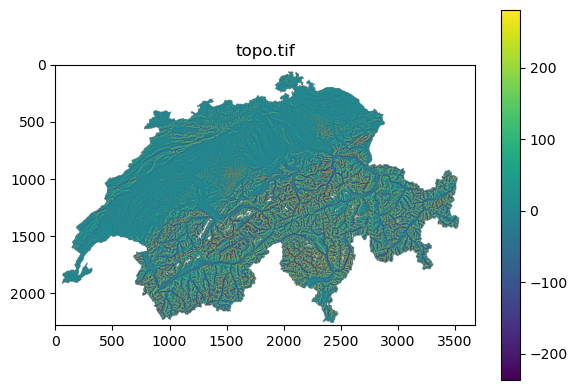

In [1]:
import rasterio
from pathlib import Path
from rasterio.plot import show
import matplotlib.pyplot as plt
import numpy as np

# open a GeoTIFF
def plot_rasters(directory):

    directory = Path(directory)

    # Get all .tif files
    tif_files = sorted(directory.glob("*.tif"))

    if len(tif_files) == 0:
        print("No TIFF files found in directory:", directory)
        return

    for tif_path in tif_files:
        with rasterio.open(tif_path) as src:
            data = src.read(1)

        # Remove nodata
        data = np.where(data == src.nodata, np.nan, data)

        # Compute 2–98% percentile stretch for better visualization
        vmin, vmax = np.nanpercentile(data, (2, 98))

        # Plot raster
        plt.figure(figsize=(6, 4))
        plt.title(tif_path.name)
        plt.imshow(data, vmin=vmin, vmax=vmax)
        plt.colorbar()
        plt.tight_layout()
        plt.show()

plot_rasters("embeddings_data_and_dictionaries/data_SDM_NCEAS/Environnement")

[  84  136  -26   14  -72  138 -137  168  -35  545]
(195291, 2)
x (195291,)


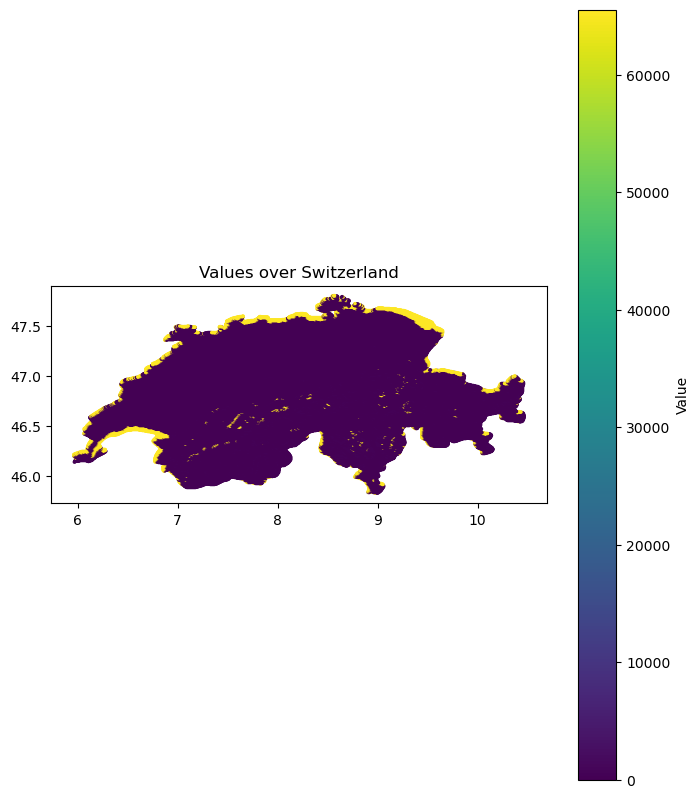

In [ ]:
import utils
import importlib
importlib.reload(utils)
import geopandas as gpd
from shapely import geometry as geom
import regionmask


def plot_country_values_aug(country_name, fct_to_plot, grid_resolution=0.1, cmap='viridis',device="cuda",comp_idx=0,save_path=None):
    grid= utils.create_country_grid("Switzerland", grid_resolution=grid_resolution) #(n_inside_ploygone,2)
    x = grid[:, 0].numpy()
    y = grid[:, 1].numpy()
    
    # Call your function with x and y separately
    values = fct_to_plot(x, y)
    # Get the country polygon
    countries = regionmask.defined_regions.natural_earth_v5_0_0.countries_10
    idx = list(countries.names).index(country_name)
    polygon = countries.polygons[idx]
    if country_name=="France":
        # Natural Earth polygons are MultiPolygon objects
        parts = list(polygon.geoms)

        # Metropolitan France lies roughly between lon -5 to 10 and lat 42 to 52
        bbox_metro = geom.box(minx=-10, miny=40, maxx=15, maxy=55)

        # Keep only polygons that intersect this box
        metro_parts = [p for p in parts if p.intersects(bbox_metro)]
        if len(metro_parts) == 0:
            raise RuntimeError("Could not isolate metropolitan France polygon.")

        polygon = geom.MultiPolygon(metro_parts)
    boundary = gpd.GeoSeries([polygon])

    fig, ax = plt.subplots(figsize=(8, 10))
    boundary.plot(ax=ax, color="none", edgecolor="black")
    from matplotlib.colors import Normalize

    norm = Normalize(vmin=np.min(values), vmax=np.max(values))
    sc = ax.scatter(x, y, c=values, cmap=cmap, norm=norm, s=2)
    plt.colorbar(sc, ax=ax, label="Value")
    ax.set_title(f"Values over {country_name}")
    if save_path is None:
        plt.show()
    else:
        plt.savefig(save_path)
lon=np.array([8.0, 8.1, 7.95, 8.2, 8.05, 8.15, 7.9, 8.25, 8.0, 8.1])  # longitudes
lat=np.array( [46.5, 46.55, 46.6, 46.45, 46.52, 46.48, 46.55, 46.5, 46.6, 46.47] )
covariates=utils.NCEAS_covariates(lon,lat)
print(covariates["topo"])

plot_country_values_aug("Switzerland", utils.NCEAS_covariates,grid_resolution=0.005)


(48831, 2)


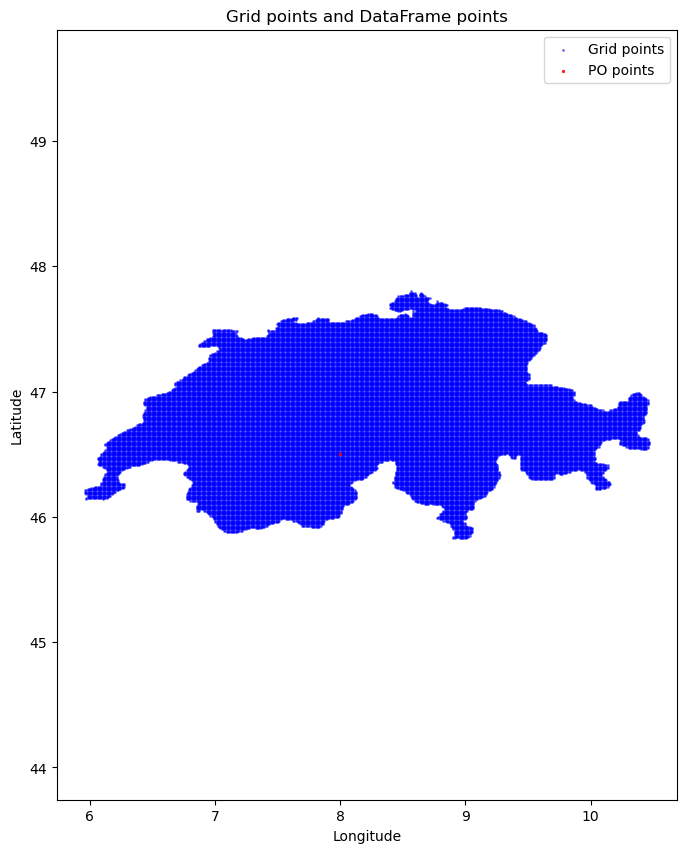

In [57]:
#test coord_trans_shift on PO data
import pandas as pd


po_data=pd.read_csv("embeddings_data_and_dictionaries/data_SDM_NCEAS/SWItrain_po.csv")
#x,y =utils.coord_trans_shift(po_data["x"].values, po_data["y"].values, order="CH_to_normal")

swiss_grid= utils.create_country_grid("Switzerland", grid_resolution=0.01)


# Convert to numpy for plotting
swiss_grid = swiss_grid.numpy()


# Plot
plt.figure(figsize=(8, 10))

# Grid points from function
plt.scatter(swiss_grid[:, 0], swiss_grid[:, 1], s=1, color='blue', alpha=0.5, label='Grid points')

# Points from DataFrame
plt.scatter(x, y, s=2, color='red', alpha=0.8, label='PO points')

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Grid points and DataFrame points")
plt.axis("equal")  # preserve aspect ratio
plt.legend()
plt.show()

In [14]:
#debugg cov_fourier_mlp class
import torch
import utils
import importlib
importlib.reload(utils)
import numpy as np
import pandas as pd
from tqdm import tqdm


'''coords=torch.tensor([[53.0812,  6.6784],
                            [51.9540,  8.6124],
                            [48.1057,  7.3169],
                            [37.2760, -1.7433],
                            [51.0574, -0.3161],
                            [51.1599, 22.9421]])'''

nbr_epochs=2
device="cuda"
batch_size=4096#4096 previoulsy #"We use batch size |B| as 512 when training on full dataset. For data-efficient settings with 20%, 10%, and 5% of the data, we use |B| as 256, 256, and 128 respectively"
save_name="test_covariate_model"
data_path="embeddings_data_and_dictionaries/bioCLIP_full_dataset_embeddings.h5"
dictionary=pd.read_csv("embeddings_data_and_dictionaries/data_dictionary_sciName")
dataloader, test_dataloader =utils.dataloader_emb(data_path,batch_size=batch_size, shuffle=True,train_ratio=0.8, sort_duplicates=True, dictionary=dictionary)

for batch in dataloader:
    print(len(batch))  # see how many elements are in the tuple
    break

pbar = tqdm(dataloader)
for i, (images, labels,_) in enumerate(pbar):
    print(labels.shape)
    coords=labels[0:1,:]
    print(coords)
    coords_numpy=coords.cpu().numpy()
    covariates_dict=utils.NCEAS_covariates(coords_numpy[:,0], coords_numpy[:,1])
    keys = ["bcc","calc","ccc","ddeg","nutri","pday","precyy","sfroyy","slope","sradyy","swb","tavecc","topo"] #it is a bit ugly but it keeps the order, if needed
    cov_np = np.stack([covariates_dict[k] for k in keys], axis=1)  # (batch, num_covariates)
    covariates = torch.from_numpy(cov_np).float()
    print(covariates)
    break

3


  0%|          | 0/619 [00:00<?, ?it/s]/home/adam/anaconda3/envs/bioCLIP/lib/python3.12/site-packages/rasterio/transform.py:529: RuntimeWarning: invalid value encountered in dot
  transform.dot(input_matrix, out=input_matrix)
/home/adam/anaconda3/envs/bioCLIP/lib/python3.12/site-packages/rasterio/transform.py:410: RuntimeWarning: invalid value encountered in cast
  new_rows = np.floor(new_rows).astype(dtype="int32")
/home/adam/anaconda3/envs/bioCLIP/lib/python3.12/site-packages/rasterio/transform.py:411: RuntimeWarning: invalid value encountered in cast
  new_cols = np.floor(new_cols).astype(dtype="int32")
  0%|          | 0/619 [00:00<?, ?it/s]

torch.Size([4096, 2])
tensor([[  47.5224, -122.3414]])
tensor([[ 2.5500e+02,  2.5500e+02,  2.5500e+02,  6.5535e+04, -3.4000e+38,
          2.5500e+02,  6.5535e+04,  2.5500e+02,  6.5535e+04,  6.5535e+04,
         -3.2768e+04, -3.2768e+04, -3.2768e+04]])
